In [1]:
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import networkx as nx
import heapq
import numpy as np


# Jaccard's Similarity:
def jaccardSim(data1, data2):
    coauthorList1 = []
    for item in data1:
        key = list(item.keys())[0]
        coauthorList1.append(key)

    coauthorList2 = []
    for item in data2:
        key = list(item.keys())[0]
        coauthorList2.append(key)

    intersect = len(set(coauthorList1).intersection(coauthorList2))
    similarityScore = (intersect / ((len(coauthorList1) + len(coauthorList2)) - intersect))

    return similarityScore

In [2]:
#Shortest path (Dijkstra algorithm)
def Shortest_path(G, start, end):
    if start == end:
        result = 0
    elif nx.has_path(G, start, end):
        neighb = []
        seen = set()
        lis = G[start] #all neighbours of start node(prof.: A.Aris)
        seen.add(start)
        for i in lis:
            heapq.heappush(neighb, (lis[i]['weight'], i)) 
            #add the neighbours of the input and their weight to heap
        while neighb:
            min_neighb = heapq.heappop(neighb)
            weight = min_neighb[0]
            node = min_neighb[1]
            seen.add(node) 
            if node == end:
                return weight
            node_neighb = G[node]  #take neigbours of neighbour
            for j in node_neighb:   
                if j not in seen:
                    is_in_neighb = False
                    for i in neighb:
                        if i[1] == j:
                            min_dist = min(i[0], node_neighb[j]['weight'] + weight)
                            #take minimum between input's neighbour and input's neighbours' neighbour
                            is_in_neighb = True
                            neighb.remove(i)
                            heapq.heappush(neighb, (min_dist, j))
                            break
                    if is_in_neighb == False:
                        heapq.heappush(neighb, (node_neighb[j]['weight'] + weight, j))
    else:
        result = float('inf')
    return result

In [3]:
def group_authors(G, t):
    dic = {}
    for i in G.nodes():
        lst = []
        for j in t:
            if i != j:
                d = Shortest_path(G, i, j)
                if d != float('inf'): #if these 2 nodes are connected
                    lst.append((d, j)) #appent its 'weight' ad 'id' to the list
        try:
            min_dist = heapq.heappop(lst) #take min. weight
            dic[i] = min_dist
            
        except:
            dic[i] = "NaN"
        
    result={}
    
    for k,v in dic.items():
        if v!='NaN': #if 2 nodes has connection
            if v[1] not in result: 
                result[v[1]]=[(k,v[0])] 
            elif v[1] in result:
                result[v[1]].append((k,v[0]))           
        
    return result

In [4]:
datab = input("Choose the database: (reduced' / 'full') : ")

if datab == "reduced":
    f = open('reduced_dblp.json', 'r')
    data = f.read()
    f.close()
if datab == "full":
    f = open('full_dblp.json', 'r')
    data = f.read()
    f.close()

#reading data from json file
dataset = json.loads(data)
type(dataset)

#Creating myDict:
myDict={}
for dic in range(len(dataset)):
    myList=[]
    confID=dataset[dic]['id_conference_int']
    pubID=dataset[dic]['id_publication_int']
    for j in range(len(dataset[dic]['authors'])):
        authorID=(dataset[dic]['authors'][j]['author_id'])
        myList=[{pubID:confID}]
        if authorID not in myDict:
            myDict[authorID]=myList            
        else:
            myDict[authorID].append({pubID:confID})

Choose the database: (reduced' / 'full') : reduced


In [5]:
#Creating Graph:
G=nx.Graph()

for data in dataset:
    for author in data["authors"]:
        for author2 in data["authors"]:
            if (author["author_id"] != author2["author_id"]) and (not((G.has_edge(author["author_id"],author2["author_id"])))):
                G.add_node(author["author_id"])
                G.add_node(author2["author_id"])
                edgeWeight= 1-jaccardSim(myDict[author["author_id"]],myDict[author2["author_id"]])
                #take list of 'publication id' and 'conference id' of each two nodes (author)
                #and compare the similarity based on this list(intersection).
                #If two authors publish more paper together,they will be more similar
                G.add_edge(author["author_id"],author2["author_id"], weight=edgeWeight)

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 7653
Number of edges: 16488
Average degree:   4.3089


### 2a

#### given a conference in input, return the subgraph induced by the set of authors who published at the input conference at least once, and computing some centralities measures (degree, closeness, betweeness) and plot them.

Search confID:3052


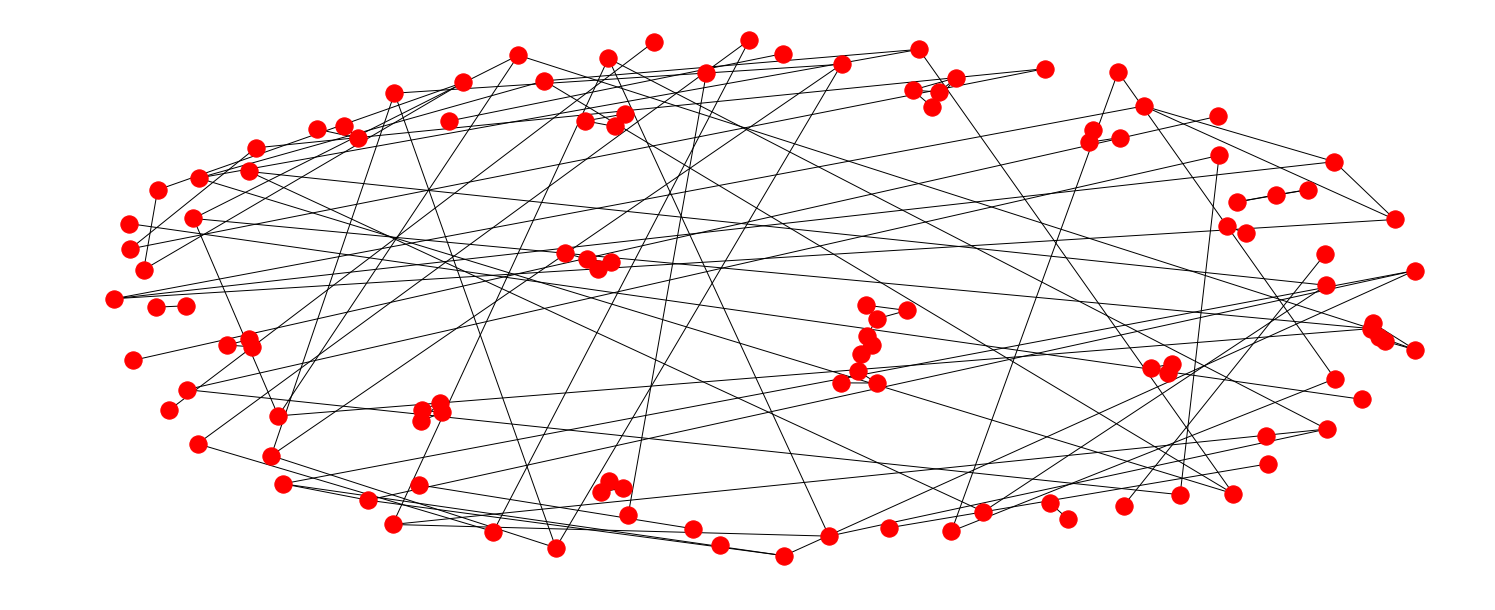

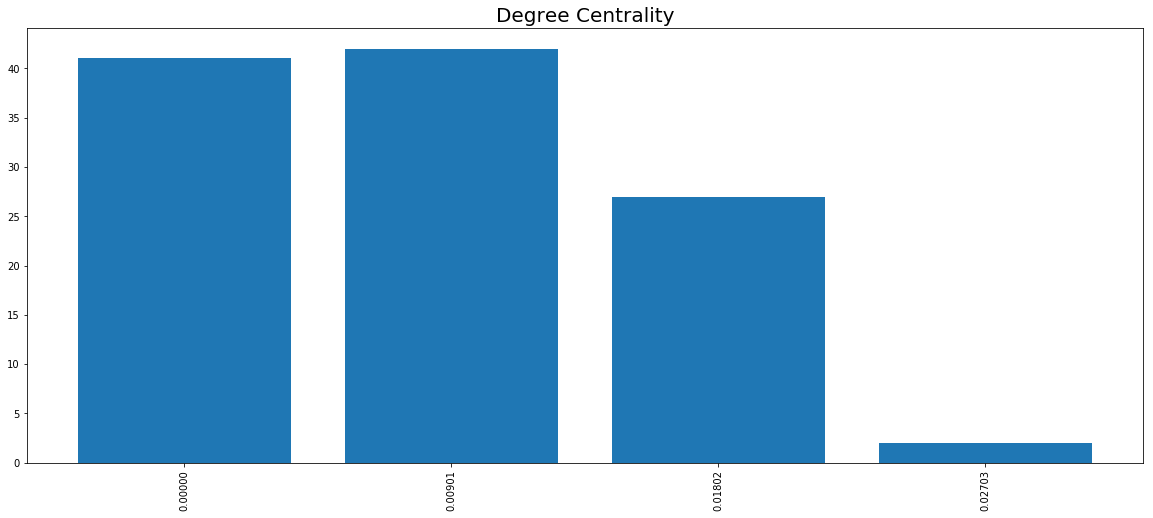

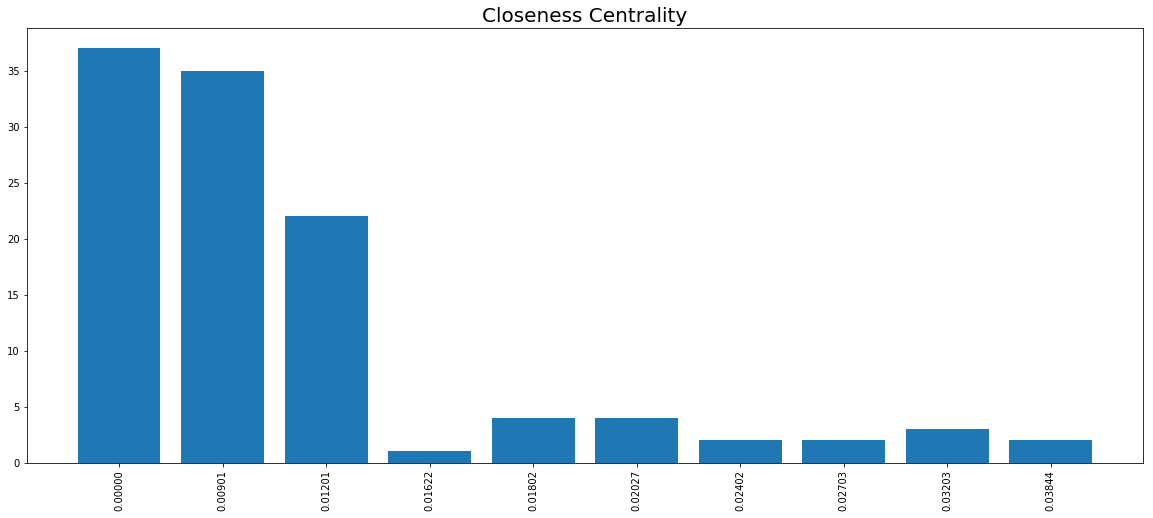

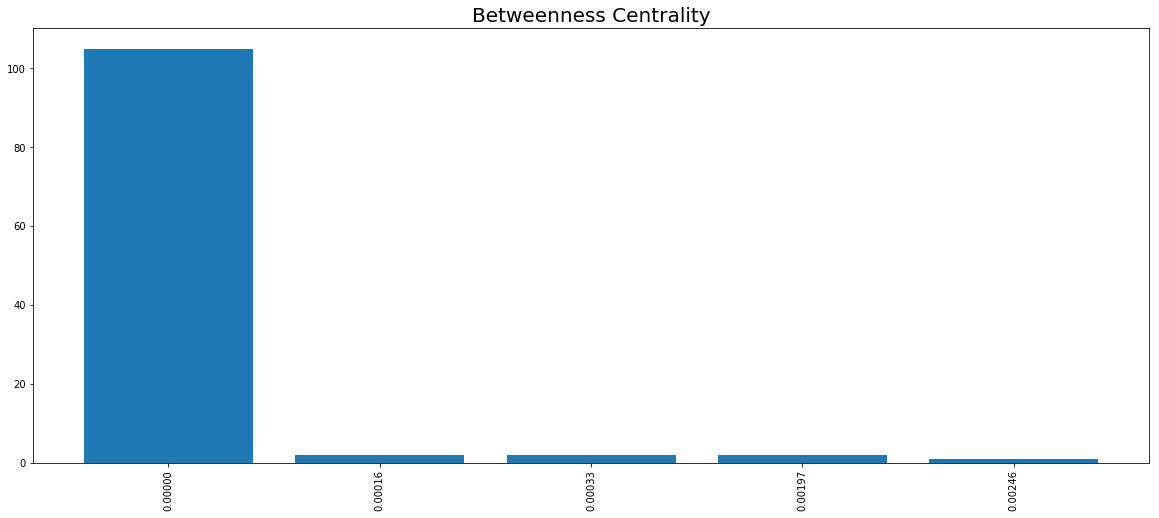

In [6]:
#input : 3052 (can be any 'conference id')

#Getting subgraph of conferences:
Conferences = {}
for book in dataset:
    confID = book['id_conference_int']  
    for author in book['authors']:
        authorID = author['author_id']
        if confID not in Conferences.keys():
            Conferences[confID] = []
        else:
            Conferences[confID].append(authorID)
#print(Conferences.keys())
        
confID = int(input("Search confID:"))      
nodeList = []
for k,v in myDict.items(): #v is the (confID,pubID)..[{161687: 3052}, {383148: 6920}]
    for j in range(len(v)):
        if(list(v[j].values())[0]==confID):
            nodeList.append(k) #list of author (nodes)
    
H = G.subgraph(nodeList)
plt.figure(figsize=(20, 8))
plt.clf()
nx.draw(H)
plt.show()
    
# Centrality measures:

degree_centrality = nx.algorithms.centrality.degree_centrality(H)
degree_dict={}
for key, values in degree_centrality.items():
    if values not in degree_dict.keys():        
        degree_dict[values]=1  #count # of degree centrality measure in graph
    else:
        degree_dict[values]+=1 
        
        
closeness_centrality = nx.algorithms.centrality.closeness_centrality(H)
closeness_dict={}
for key, values in closeness_centrality.items():
    if values not in closeness_dict.keys():        
        closeness_dict[values]=1
    else:
        closeness_dict[values]+=1
        
betweenness_centrality = nx.algorithms.centrality.betweenness_centrality(H)    
betweenness_dict={}
for key, values in betweenness_centrality.items():
    if values not in betweenness_dict.keys():        
        betweenness_dict[values]=1
    else:
        betweenness_dict[values]+=1

def plot(dict,text):
    x = np.arange(len(dict))
    y = [i for i in dict.values()]
    plt.figure(figsize=(20, 8))
    plt.bar(x, y)
    plt.title(text,fontsize=20)
    plt.xticks(x, sorted(("%.5f" % a for a in dict.keys())),rotation=90)
    plt.show()

plot(degree_dict,text='Degree Centrality')
plot(closeness_dict,text='Closeness Centrality')
plot(betweenness_dict,text='Betweenness Centrality')

### 2b

#### Given in input an author node and an integer d, get the subgraph induced by the nodes that have hop distance at most equal to d.Then, visualize the graph

Search authorID: 256176
Enter Hop Distance: 3


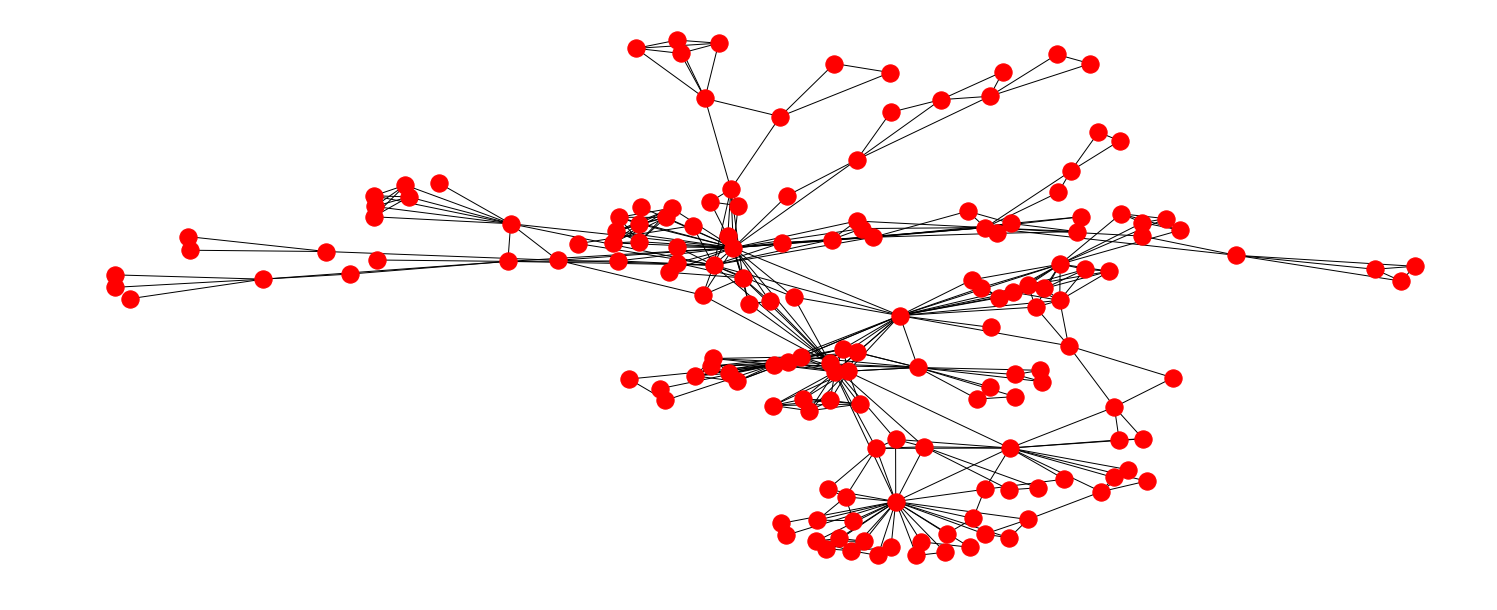

In [7]:
#input: 256176 (can be any node)

searchauthorID = int(input("Search authorID: ")) #for example - 256176
hopDistance=int(input("Enter Hop Distance: "))
test=nx.ego_graph(G, searchauthorID, radius=hopDistance,center=True) 
plt.figure(figsize=(20, 8))
plt.clf()
nx.draw(test)
plt.show()

### 3a

#### takes in input an author (id) and returns the weight of the shortest path that connects the input author node with A.Aris node (my prof.).

In [8]:
#input : 79993  (can be any node or author_id )

author = int(input("Search the authorID to calculate the shortest path with Aris: "))
print(Shortest_path(G,256176, author))

Search the authorID to calculate the shortest path with Aris: 79993
2.5357142857142856


### 3b

##### we input subset of nodes.For each nodes in entire graph we will group them based on shortest path.if node has path to more than one input nodes then,this node will be assigned to the node(input) which path is shortest

In [9]:
#input : 9503  255902  9070  239007  189237

t = list(map(int,input("insert a list of authors' ID : ").split()))
result=group_authors(G, t)
for k,v in result.items():
    print ('Node {} group : '.format(k))
    print (v,"\n")

insert a list of authors' ID : 9503  255902  9070  239007  189237
Node 9503 group : 
[(93126, 0.75), (23845, 1.4166666666666667), (208589, 1.4166666666666667), (255926, 0.6666666666666667), (9505, 0.6666666666666667), (255300, 1.3333333333333335), (21056, 1.8333333333333335), (70758, 1.8333333333333335), (93127, 0.6666666666666667), (94093, 1.1666666666666667), (263188, 1.1666666666666667), (217561, 1.1666666666666667), (59385, 1.1666666666666667), (9504, 0.5), (695172, 1.1666666666666667)] 

Node 255902 group : 
[(127810, 0.6666666666666667), (256500, 0.6666666666666667), (816142, 0.6666666666666667)] 

Node 9070 group : 
[(9068, 0.0), (9046, 0.0), (9069, 0.0)] 

Node 239007 group : 
[(124828, 0.0), (189237, 0.0)] 

Node 189237 group : 
[(239007, 0.0)] 

